Using device: cuda
Processing file: ../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg000.mat
--- XGBoost Metrics ---
MAE: 0.0958
MAPE: 0.3426
MSE: 0.0157
R^2: -0.0000
Epoch [1/100], Train Loss: 0.0230, Val Loss: 0.0157
Epoch [2/100], Train Loss: 0.0171, Val Loss: 0.0158
Epoch [3/100], Train Loss: 0.0166, Val Loss: 0.0157
Epoch [4/100], Train Loss: 0.0167, Val Loss: 0.0158
Epoch [5/100], Train Loss: 0.0164, Val Loss: 0.0158
Epoch [6/100], Train Loss: 0.0166, Val Loss: 0.0158
Epoch [7/100], Train Loss: 0.0163, Val Loss: 0.0157
Epoch [8/100], Train Loss: 0.0162, Val Loss: 0.0158
Epoch [9/100], Train Loss: 0.0162, Val Loss: 0.0158
Epoch [10/100], Train Loss: 0.0162, Val Loss: 0.0157
Epoch [11/100], Train Loss: 0.0161, Val Loss: 0.0158
Epoch [12/100], Train Loss: 0.0161, Val Loss: 0.0157
Epoch [13/100], Train Loss: 0.0161, Val Loss: 0.0157
Epoch [14/100], Train Loss: 0.0161, Val Loss: 0.0157
Epoch [15/100], Train Loss: 0.0160, Val Loss: 0.0157
Epoch [16/100], Train Loss: 0.

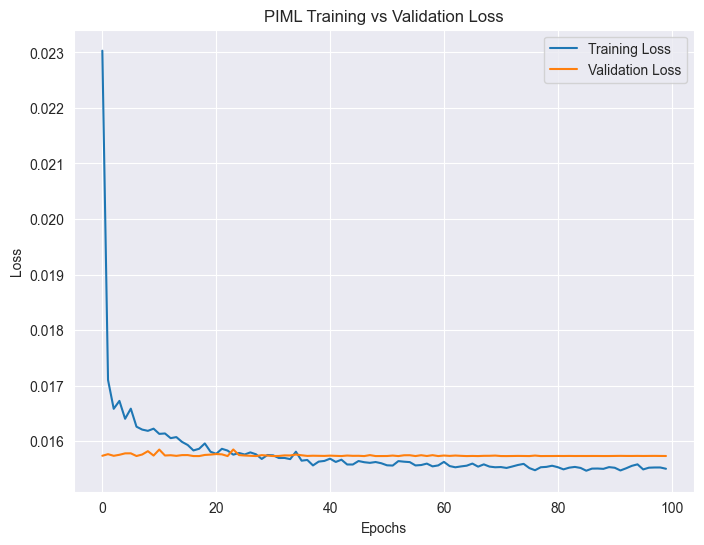

--- PIML Metrics ---
MAE: 0.0957
MAPE: 0.3411
MSE: 0.0157
R^2: -0.0001


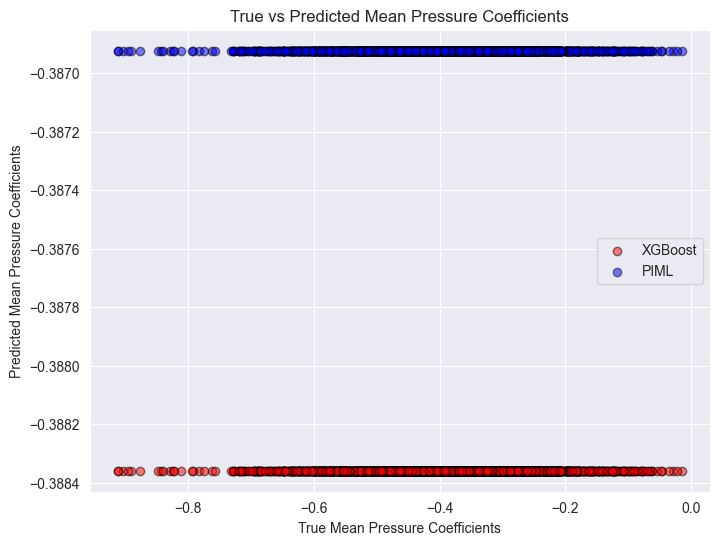

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, accuracy_score, precision_score
import xgboost as xgb

# --- Device Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Helper Function to Load and Process Data ---
def load_mat_file(file_path):
    mat_data = loadmat(file_path)

    # Extract required fields with validation
    try:
        wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']
        if len(wind_pressure_coefficients.shape) == 1:
            wind_pressure_coefficients = wind_pressure_coefficients[:, np.newaxis]
        mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)

        roof_pitch = mat_data['Roof_pitch'].flatten()
        sample_frequency = mat_data['Sample_frequency'].flatten()
        building_depth = mat_data['Building_depth'].flatten()
        building_breadth = mat_data['Building_breadth'].flatten()
        building_height = mat_data['Building_height'].flatten()
        wind_azimuth = mat_data['Wind_azimuth'].flatten()

        num_samples = mean_pressure_coefficients.shape[0]

        features = pd.DataFrame({
            "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
            "Sample_frequency": np.tile(sample_frequency, num_samples // len(sample_frequency)),
            "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
            "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
            "Building_height": np.tile(building_height, num_samples // len(building_height)),
            "Wind_azimuth": np.tile(wind_azimuth, num_samples // len(wind_azimuth))
        })
        features["Mean_pressure_coefficient"] = mean_pressure_coefficients

        return features

    except KeyError as e:
        raise ValueError(f"Key missing in .mat file: {e}")

# --- Process Multiple Files ---
def process_multiple_files(file_paths):
    dataframes = []
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        dataframes.append(load_mat_file(file_path))
    return pd.concat(dataframes, ignore_index=True)

# --- File Paths ---
file_paths = [
    "../data/Low-rise with eaves/roof type a/height 1;4/Cp_ts_RAH06_deg000.mat"# Add additional file paths as needed
]

# --- Load Data ---
data = process_multiple_files(file_paths)

# --- Feature Engineering ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X = data.drop(columns=["Mean_pressure_coefficient"])
y = data["Mean_pressure_coefficient"]

# Transform features
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- XGBoost Model ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Metrics for XGBoost ---
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Metrics ---")
print(f"MAE: {mae_xgb:.4f}")
print(f"MAPE: {mape_xgb:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"R^2: {r2_xgb:.4f}")

# --- Physics-Informed Machine Learning (PIML) ---
class PressureDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = PressureDataset(X_train_scaled, y_train.values)
test_dataset = PressureDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define PyTorch model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = RegressionModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Train PIML model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_losses.append(val_loss / len(test_loader))
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PIML Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate PIML model
y_pred_p = []
y_true_p = []
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred_p.append(outputs.squeeze().cpu().numpy())
        y_true_p.append(targets.cpu().numpy())

y_pred_p = np.concatenate(y_pred_p)
y_true_p = np.concatenate(y_true_p)

mae_piml = mean_absolute_error(y_true_p, y_pred_p)
mape_piml = mean_absolute_percentage_error(y_true_p, y_pred_p)
mse_piml = mean_squared_error(y_true_p, y_pred_p)
r2_piml = r2_score(y_true_p, y_pred_p)

print("--- PIML Metrics ---")
print(f"MAE: {mae_piml:.4f}")
print(f"MAPE: {mape_piml:.4f}")
print(f"MSE: {mse_piml:.4f}")
print(f"R^2: {r2_piml:.4f}")

# --- Comparison Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='red', edgecolor='k', label='XGBoost')
plt.scatter(y_true_p, y_pred_p, alpha=0.5, color='blue', edgecolor='k', label='PIML')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.legend()
plt.grid(True)
plt.show()
